<a href="https://colab.research.google.com/github/guscabmelo/ML-PROJECTS/blob/main/TRANSFER_LEARNING_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
##  IMPORTANDO AS BIBLIOTECAS

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array


In [6]:
# Função para carregar imagens de um diretório específico
def load_images_from_directory(directory, target_size):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=target_size)
            x = img_to_array(img)
            images.append(x)
    return images

In [7]:
# Definindo os diretórios das imagens
cat_directory = '/content/drive/MyDrive/DATASET/Cat'
dog_directory = '/content/drive/MyDrive/DATASET/Dog'
tamanho_alvo = (224, 224)

# Carregando as imagens
cat_images = load_images_from_directory(cat_directory, tamanho_alvo)
dog_images = load_images_from_directory(dog_directory, tamanho_alvo)


In [8]:
# Criando o dataset
data = [{"x": img, "y": 0} for img in cat_images] + [{"x": img, "y": 1} for img in dog_images]
random.shuffle(data)

# Dividindo o dataset
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [9]:
# Separando dados e rótulos
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# Normalizando os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convertendo rótulos para one-hot encoding
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [10]:
# Construindo a rede neural
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [11]:
# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))


Epoch 1/10
2/2 [==============================] - 20s 3s/step - loss: 0.7147 - accuracy: 0.4786 - val_loss: 0.6900 - val_accuracy: 0.5333
Epoch 2/10
2/2 [==============================] - 15s 3s/step - loss: 0.7269 - accuracy: 0.4643 - val_loss: 0.6915 - val_accuracy: 0.5333
Epoch 3/10
2/2 [==============================] - 11s 2s/step - loss: 0.6831 - accuracy: 0.5143 - val_loss: 0.6960 - val_accuracy: 0.4667
Epoch 4/10
2/2 [==============================] - 13s 3s/step - loss: 0.6833 - accuracy: 0.5143 - val_loss: 0.7026 - val_accuracy: 0.4667
Epoch 5/10
2/2 [==============================] - 14s 1s/step - loss: 0.6864 - accuracy: 0.5357 - val_loss: 0.7051 - val_accuracy: 0.4667
Epoch 6/10
2/2 [==============================] - 11s 2s/step - loss: 0.6763 - accuracy: 0.5857 - val_loss: 0.7014 - val_accuracy: 0.4667
Epoch 7/10
2/2 [==============================] - 9s 1s/step - loss: 0.6810 - accuracy: 0.5357 - val_loss: 0.6969 - val_accuracy: 0.4667
Epoch 8/10
2/2 [===================

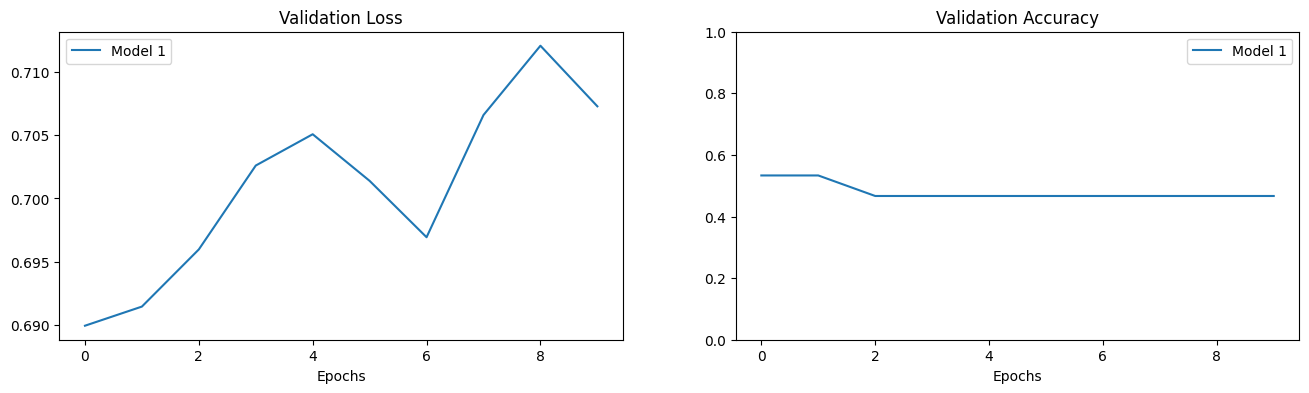

In [12]:
# Visualizando o histórico de treinamento
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Model 1")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Model 1")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

In [13]:

# Avaliando o modelo
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6927992105484009
Test accuracy: 0.5483871102333069


In [14]:
# Fine-Tuning do VGG16
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
inp = vgg.input
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = Model(inp, out)

# Congelando todas as camadas do VGG16, exceto a última
for layer in model_new.layers[:-1]:
    layer.trainable = False

553467096/553467096 [==============================] - 3s 0us/step


In [15]:
# Compilando o novo modelo
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

# Treinando o novo modelo
history2 = model_new.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

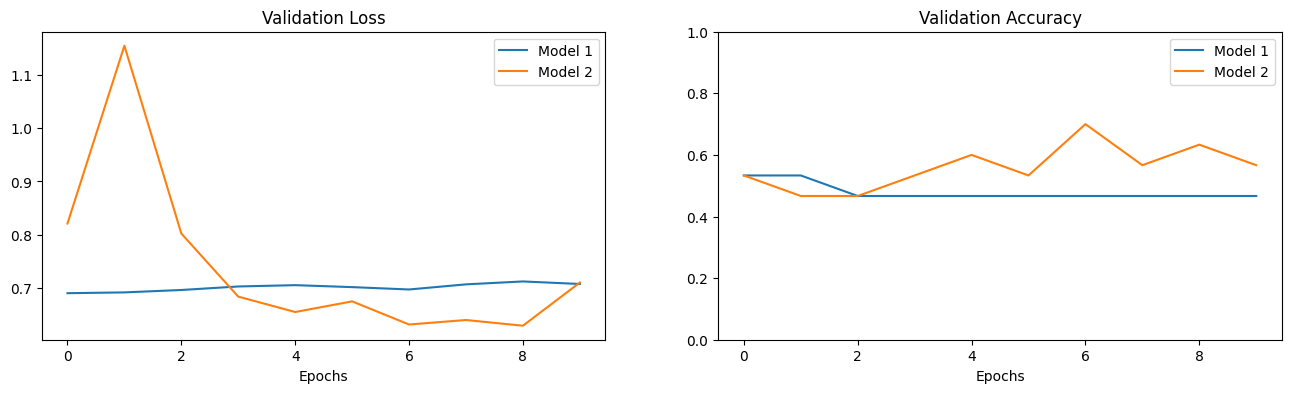

In [16]:
# Visualizando o histórico de treinamento (Modelos Original e Ajustado)
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Model 1")
ax.plot(history2.history["val_loss"], label="Model 2")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Model 1")
ax2.plot(history2.history["val_accuracy"], label="Model 2")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

In [17]:
# Avaliando o novo modelo
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6723505258560181
Test accuracy: 0.5483871102333069


In [28]:
# Função de previsão para imagem
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


test_image_path = '/content/drive/MyDrive/DATASET/test/teste (200).jpg' #### VERIFICAR
img, x = get_image(test_image_path)

In [29]:
# Lista de categorias para prever
categories = ['Cat', 'Dog']
if len(categories) != num_classes:
    raise ValueError(f"The number of class names ({len(categories)}) does not match the number of classes predicted by the model ({num_classes}).")


In [30]:
# Fazendo a previsão para a imagem carregada
probabilities = model_new.predict([x])
predicted_class_index = np.argmax(probabilities[0])
predicted_class_name = categories[predicted_class_index]
predicted_class_probability = probabilities[0][predicted_class_index]


1/1 [==============================] - 1s 707ms/step


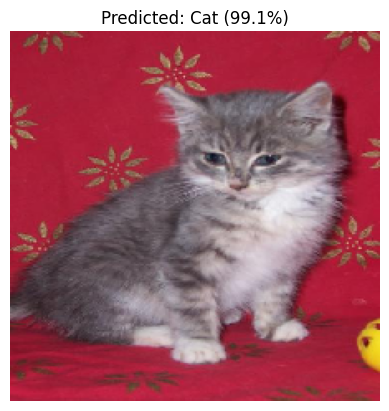

In [31]:
# Mostrando a imagem com a classe prevista e a probabilidade
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_probability:.1%})")
plt.axis('off')
plt.show()

In [22]:
#FIM

In [23]:
print("fim")

fim
